# Wasserstein distance vs KL divergance

Toy models to check that the difference between the assesment of wasserstein and KL is in sensitivity of divergances in tails.



In [1]:
from scipy.stats import wasserstein_distance, norm
from matplotlib import pyplot as plt
import numpy as np


In [2]:
def select_n_points(n, x, center=True):
    if not n:
        return np.array([], dtype=int)
    if center:
        ps = norm.pdf(x, scale=0.5)
    else:
        ps = -norm.pdf(x, scale=1.5)
    probs = np.random.uniform(size=x.size)
    selected = np.argsort(ps*probs)[-n:]
    return selected
    

In [46]:


n=100_000
change = int(n/100)

min_value = -15
max_value = 15
bins = np.arange(min_value, max_value, 0.5)



def generate_datasets(tail_shift, center_shift, center_acitvation=1., suptitle=None, n_trials=100):
    
    colours = plt.cm.cool(np.linspace(0, 1, n_trials))

    datasets = []
    base_datasets = []
    
    
    for i in range(n_trials):
        base = norm.rvs(size=n)
        moved = base.copy()
        
        if tail_shift == "mean":
            mean_shift = i/n_trials
            moved += mean_shift
        elif tail_shift == "std_grow":
            std_shift = 1 + i/n_trials
            moved *= std_shift
        elif tail_shift == "std_shrink":
            std_shift = (n_trials - i)/n_trials
            moved *= std_shift
        else:
            center_change = int(change*i/(n_trials-1))
            tail_change = change-center_change
            
            if center_shift is None:
                # when there is just one thing in play, we always want to go from less to more
                tail_change = center_change
            
            center_idxs = select_n_points(int(center_acitvation*center_change), base, True)
            tail_idxs = select_n_points(tail_change, base, False)

            if center_shift is not None:
                moved[center_idxs] = center_shift(base[center_idxs])
            if tail_shift is not None:
                moved[tail_idxs] = tail_shift(base[tail_idxs])
            
        
        datasets += [moved]
        base_datasets += [base]

    if suptitle is not None:
        # plotting
        
        hist_args = dict(histtype='step', bins=bins)
        
        fig, axarr = plt.subplots(2, 1, sharex=True)
        fig.suptitle(suptitle)

        
        if tail_shift is None or center_shift is None:
            labels = "no change", "max change"
        else:
            labels = "change tails", "change center"
        #for ax in axarr:
        ax=axarr[0]
        ax.plot([], [], c=colours[0], label=labels[0])
        ax.plot([], [], c=colours[-1], label=labels[1])
        ax.set_ylabel("frequency")
        ax.set_xlabel("x")
    
        base_bin_values, _, _  = ax.hist(base_datasets[0], color='k', linewidth=5, **hist_args)
        bin_values, _ , _ = ax.hist(datasets, color=colours, **hist_args)
        
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        for c, vals in zip(colours, bin_values):
            axarr[1].hist(bin_centers, weights=vals-base_bin_values, color=c, **hist_args)
        axarr[1].set_ylabel("difference")
        
        axarr[0].legend()
        axarr[0].semilogy()
        
        
    
    probabilities = [np.histogram(ds, bins=bins, density=True)[0] for ds in datasets] 
    base_probabilities = [np.histogram(ds, bins=bins, density=True)[0] for ds in base_datasets] 

    return datasets, base_datasets, probabilities, base_probabilities, colours



In [47]:
def fixed(x):
    return np.ones(x.shape[0])*2

def no_op(x):
    return x


def shrink(x):
    return x*0.1

def grow(x):
    return x*2

def positive_sign(x):
    return np.abs(x)

def flatten_center(x):
    if x.shape[0] == 0:
        return x
    width = 2*np.std(x)
    return np.random.uniform(-width, width, x.shape[0])


def flatten_tails(x):
    if x.shape[0] == 0:
        return x
    distance = np.mean(np.abs(x))
    width = np.std(np.abs(x))
    return (distance + np.random.uniform(-width, width, x.shape[0]))*np.sign(x)
    

In [95]:
from scipy.stats import wasserstein_distance
def wasserstein_d(u: np.ndarray, v: np.ndarray, weight_u: np.ndarray = None, weight_v: np.ndarray = None) -> float:
    """
    Calculate the normalized Wasserstein distance between two samples.
    
    Parameters:
    u (np.ndarray): Array of sample points from the first distribution.
    v (np.ndarray): Array of sample points from the second distribution.
    weight_u (np.ndarray, optional): Array of weights for the first sample. Default is None.
    weight_v (np.ndarray, optional): Array of weights for the second sample. Default is None.
    
    Returns:
    float: Normalized Wasserstein distance between the two distributions.
    """
    
    # Calculate the Wasserstein distance
    wasserstein_value = wasserstein_distance(u, v, weight_u, weight_v)
    
    # Compute standard deviation for normalization
    if weight_u is None:
        std_u = np.std(u, ddof=1)  # Using ddof=1 for unbiased estimate of standard deviation
    else:
        mean_u = np.average(u, weights=weight_u)
        variance_u = np.average((u - mean_u) ** 2, weights=weight_u)
        std_u = np.sqrt(variance_u)
    
    # Normalize Wasserstein distance
    if std_u != 0:
        wasserstein_value /= std_u
    else:
        raise ValueError("Standard deviation of the first distribution is zero, cannot normalize.")
    
    return wasserstein_value

from scipy.stats import entropy
def quantiled_kl_divergence(
    sample_ref: np.ndarray,
    sample_gen: np.ndarray,
    num_quantiles: int = 30,
):
    """Calculate the KL divergence using quantiles on sample_ref to define the bounds.

    Parameters
    ----------
    sample_ref : np.ndarray
        The first sample to compare (this is the reference, so in the context of
        jet generation, those are the real jets).
    sample_gen : np.ndarray
        The second sample to compare (this is the model/approximation, so in the
        context of jet generation, those are the generated jets).
    num_quantiles : int
        The number of bins to use for the histogram. Those bins are defined by
        equiprobably quantiles of sample_ref.
       
    """
    bin_edges = np.quantile(sample_ref, np.linspace(0, 1, num_quantiles + 1))
    bin_edges[0] = float("-inf")
    bin_edges[-1] = float("inf")
    pk = np.histogram(sample_ref, bin_edges)[0] / len(sample_ref) + 1e-6
    qk = np.histogram(sample_gen, bin_edges)[0] / len(sample_gen) + 1e-6
    kl = entropy(pk, qk)
    
    return kl


def run(tail_shift, center_shift, center_activation=1., suptitle=None, n_trials=100):

    datasets, base_datasets, probabilities, base_probabilities, colours = generate_datasets(tail_shift, center_shift, center_activation, suptitle, n_trials)
    
    ws_distances = np.fromiter((wasserstein_d(bs, ds) for bs, ds in zip(base_datasets, datasets)), dtype=float)
    kl_divs = np.fromiter((quantiled_kl_divergence(bs, ds) for bs, ds in zip(base_datasets, datasets)), dtype=float)
    
    xs = np.linspace(0, 1, n_trials)
    ys = ws_distances/kl_divs
    log_ys = np.log(ys)
    mask = (~np.isnan(log_ys))*(~np.isinf(log_ys))
    log_ys = log_ys[mask]
    xs = xs[mask]
    ys = ys[mask]

    gradient, bias = np.polyfit(xs, log_ys, 1)
    if suptitle is not None:
        fig, axarr = plt.subplots(1, 2, figsize=(12, 4))
        
        axarr[0].scatter(ws_distances, kl_divs, c=colours)
        axarr[1].scatter(xs, ys, c=colours[mask])
        axarr[0].set_ylabel("KL divergance")
        axarr[0].set_xlabel("Wasserstein distance")
        
        
        if isinstance(tail_shift, str):
            change_type = ""
        elif tail_shift is None:
            change_type = "center "
        else:
            change_type = "tail "
        
        if center_shift is None or tail_shift is None:
            axarr[1].scatter([], [], c=colours[0], label='no change')
            axarr[1].scatter([], [], c=colours[-1], label=f'max {change_type}change')
            axarr[1].set_xlabel(f"no change into max {change_type}change")
        else:
            axarr[1].scatter([], [], c=colours[0], label='change tails')
            axarr[1].scatter([], [], c=colours[-1], label='change center')
            axarr[1].set_xlabel("ratio tail to center change")
    
        
        axarr[1].set_ylabel(f"Wasserstein/KL ratio")
        axarr[1].plot(xs, np.exp(xs*gradient+bias), c=(0.5, 0.5, 0.5, 0.5), lw=4, label=f"exp({gradient:.3}x+{bias:.3})")
    
        
            
        axarr[1].semilogy()
        axarr[1].legend()
        fig.suptitle(suptitle)

    return gradient, bias, xs, ys

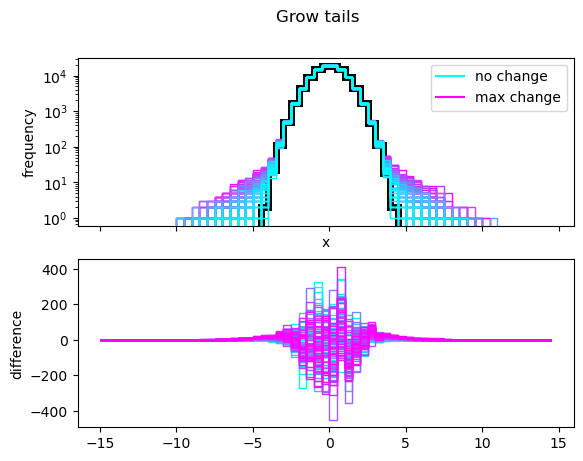

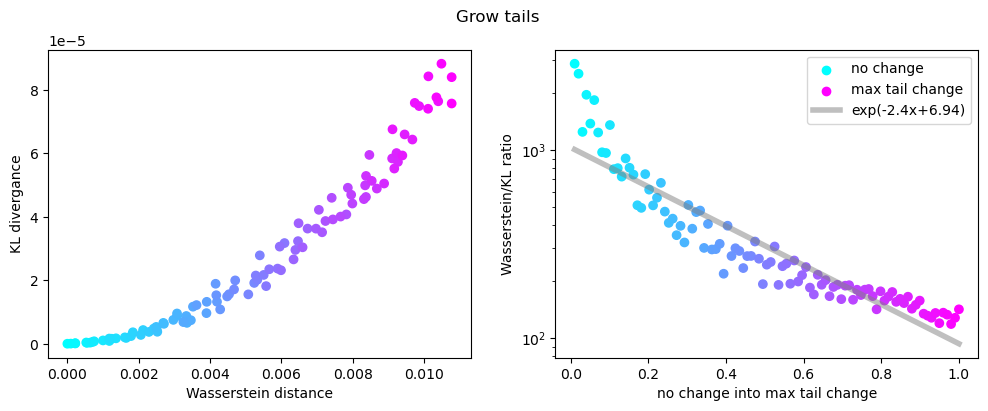

In [96]:
grad_grow_tails, bias_grow_tails, _, _ =run(grow, None, suptitle="Grow tails")

In [70]:
activations = np.linspace(0.1, 1., 10)
gradients = np.zeros(10)
biases = np.zeros(10)
points = []
for i, a in enumerate(activations):

    gradient, bias, xs, ys = run(None, shrink, n_trials=100, center_activation=a)
    gradients[i] = gradient
    biases[i] = bias
    points.append((xs, ys))
    print(i)

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'exponent')

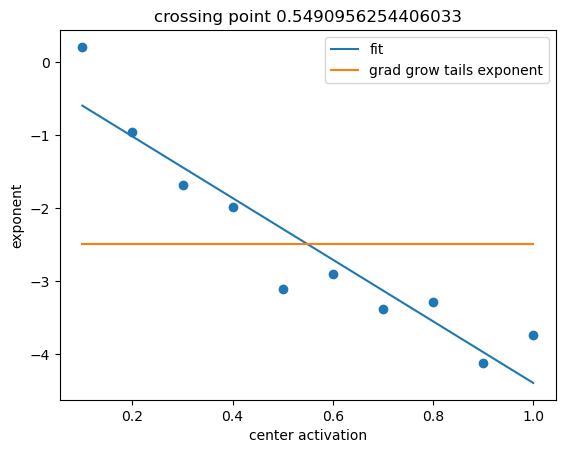

In [89]:

plt.scatter(activations, gradients)

g, b = np.polyfit(activations, gradients, 1)
plt.plot(activations, g*activations+b, label="fit")
plt.plot([0.1, 1.], [grad_grow_tails, grad_grow_tails], label="grad grow tails exponent")
plt.title(f"crossing point {(grad_grow_tails-b)/g}")
plt.legend()
plt.xlabel("center activation")
plt.ylabel("exponent")

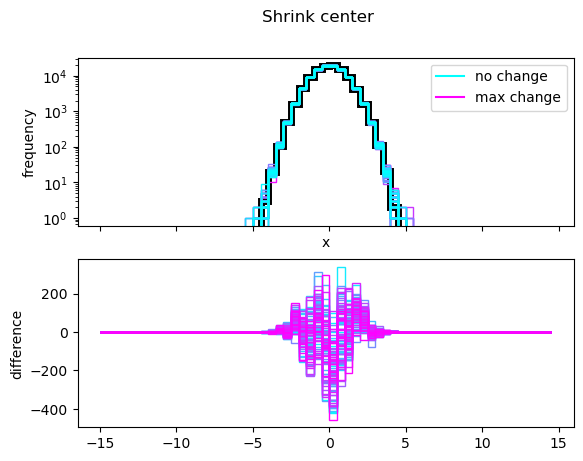

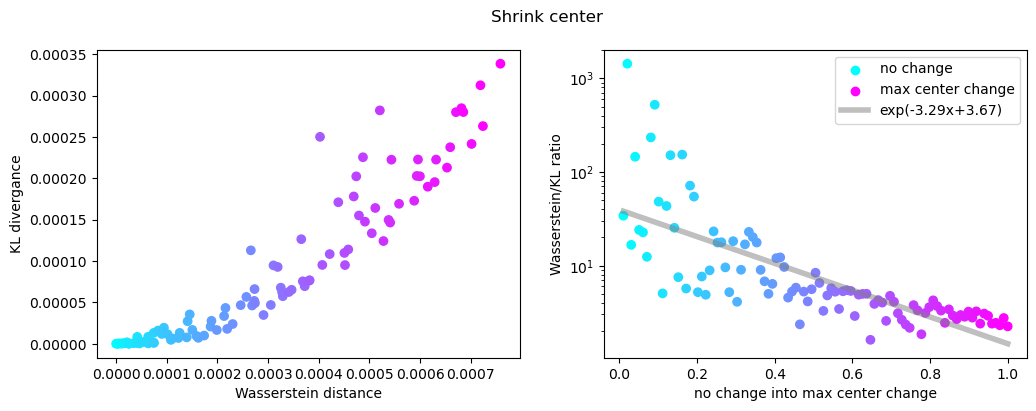

In [113]:
_ = run(None, shrink, n_trials=100, suptitle="Shrink center")

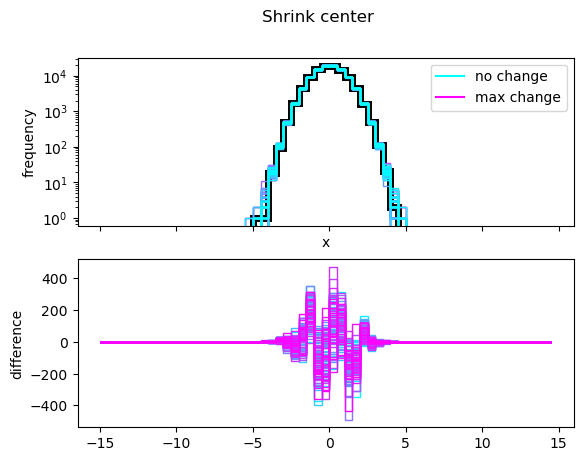

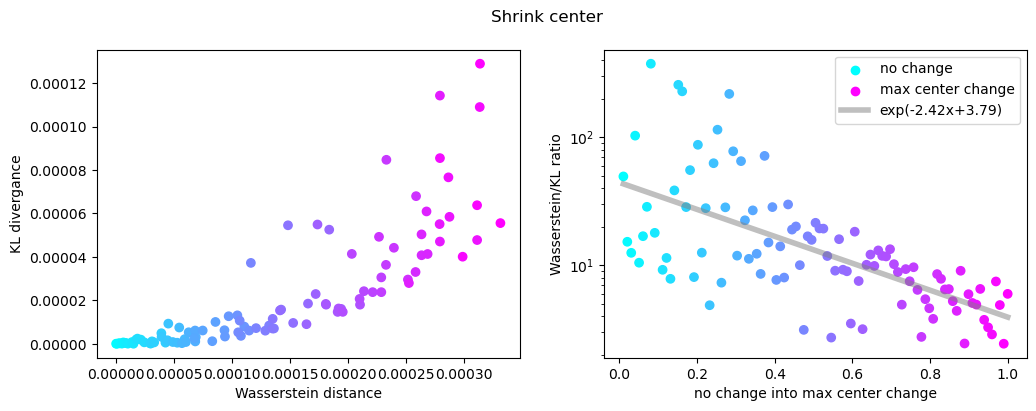

In [97]:
_ = run(None, shrink, n_trials=100, suptitle="Shrink center", center_activation=0.55)

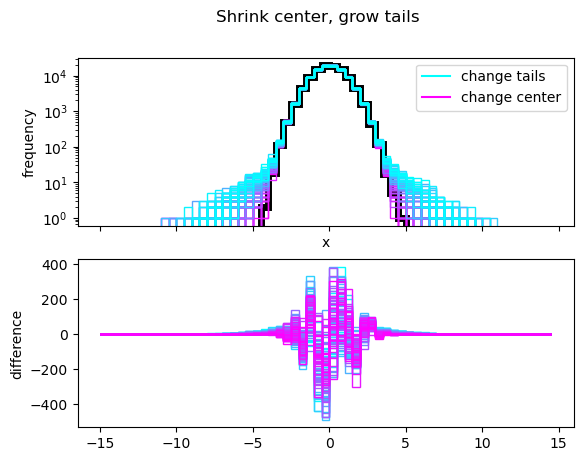

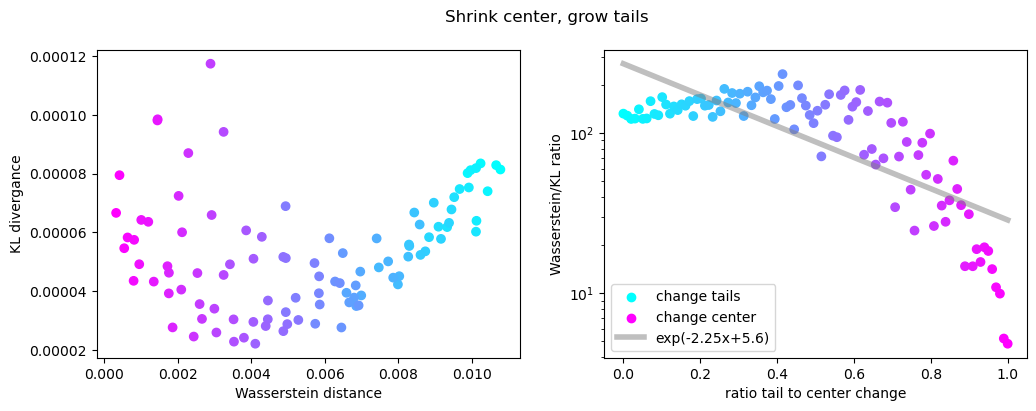

In [98]:
grad_shrink_grow, bias_shrink_grow, _, _ = run(grow, shrink, suptitle="Shrink center, grow tails", center_activation=0.55)

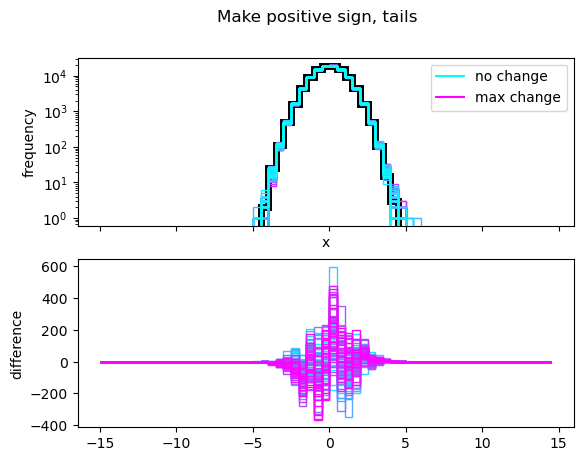

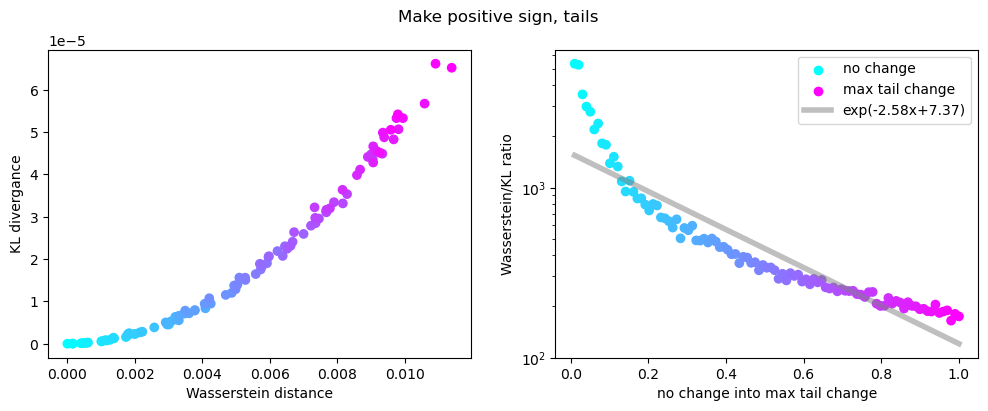

In [99]:
grad_posi_tails, bias_posi_tails, _, _ =run(positive_sign, None, suptitle="Make positive sign, tails")

In [111]:
activations2 = np.linspace(0.8, 2., 12)
gradients2 = np.zeros(12)
biases2 = np.zeros(12)
points2 = []
for i, a in enumerate(activations2):

    gradient, bias, xs, ys = run(None, positive_sign, n_trials=100, center_activation=a)
    gradients2[i] = gradient
    biases2[i] = bias
    points2.append((xs, ys))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11


Text(0, 0.5, 'exponent')

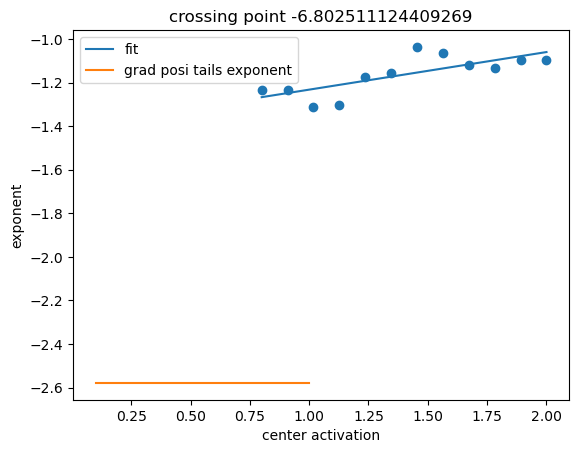

In [112]:

plt.scatter(activations2, gradients2)

g, b = np.polyfit(activations2, gradients2, 1)
plt.plot(activations2, g*activations2+b, label="fit")
plt.plot([0.1, 1.], [grad_posi_tails, grad_posi_tails], label="grad posi tails exponent")
plt.title(f"crossing point {(grad_posi_tails-b)/g}")
plt.legend()
plt.xlabel("center activation")
plt.ylabel("exponent")

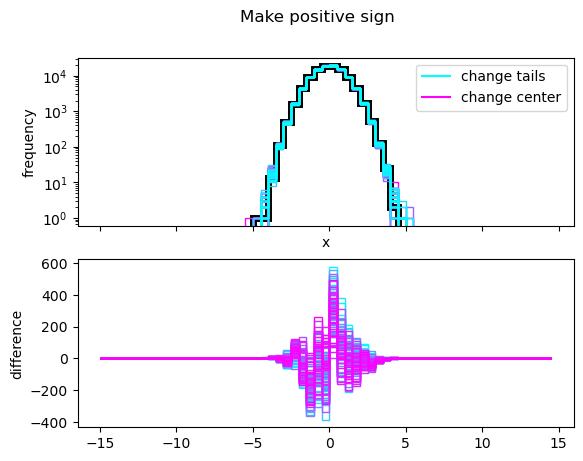

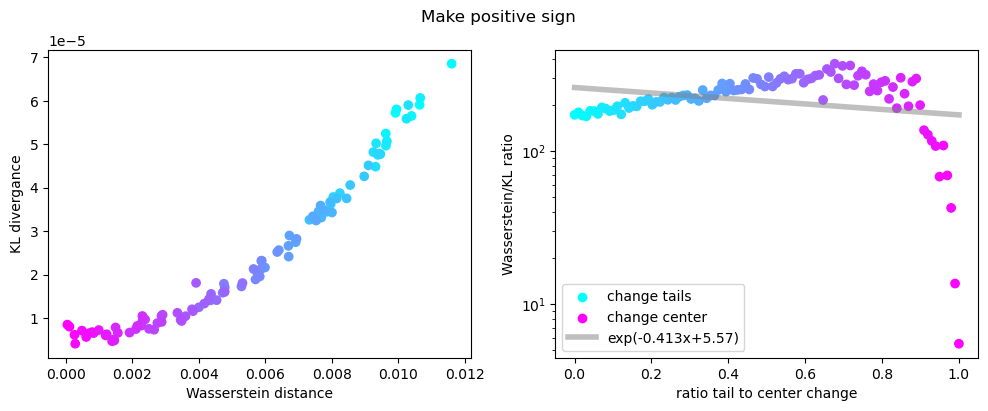

In [101]:
_ = run(positive_sign, positive_sign, suptitle="Make positive sign", center_activation=0.1)

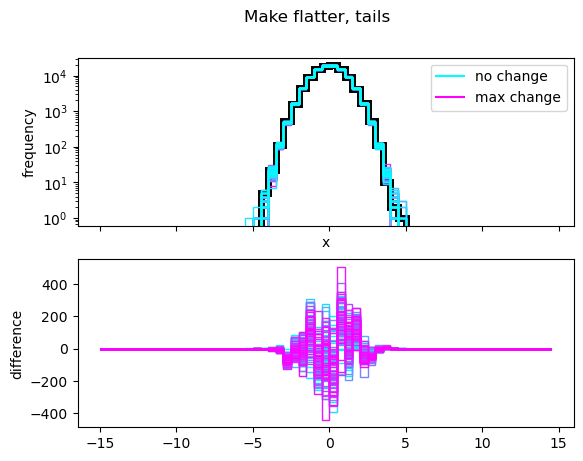

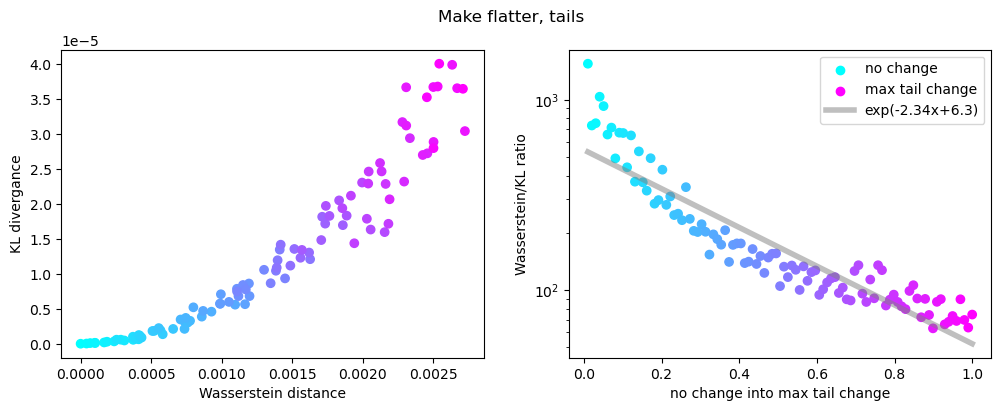

In [102]:
grad_flat_tails, bias_flat_tails, _, _ =run(flatten_tails, None, suptitle="Make flatter, tails")

In [87]:
gradients3 = np.zeros(10)
biases3 = np.zeros(10)
points3 = []
for i, a in enumerate(activations):

    gradient, bias, xs, ys = run(None, flatten_center, n_trials=100, center_activation=a)
    gradients3[i] = gradient
    biases3[i] = bias
    points3.append((xs, ys))
    print(i)

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'exponent')

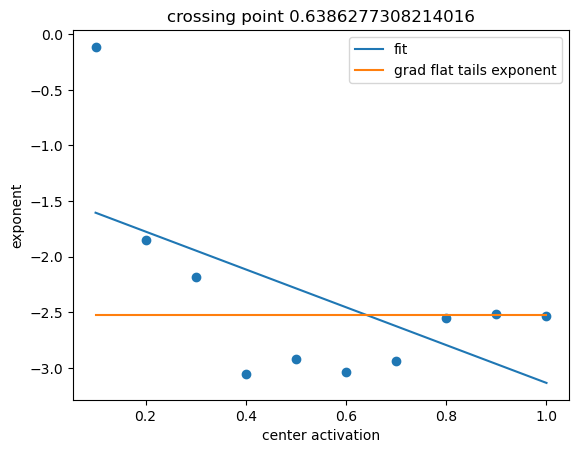

In [91]:

plt.scatter(activations, gradients3)

g, b = np.polyfit(activations, gradients3, 1)
plt.plot(activations, g*activations+b, label="fit")
plt.plot([0.1, 1.], [grad_flat_tails, grad_flat_tails], label="grad flat tails exponent")
plt.title(f"crossing point {(grad_flat_tails-b)/g}")
plt.legend()
plt.xlabel("center activation")
plt.ylabel("exponent")

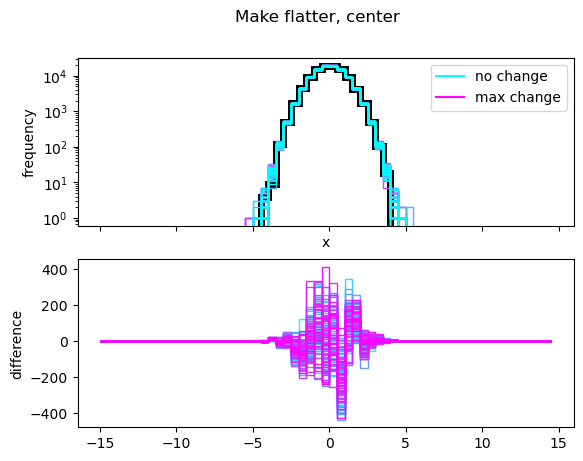

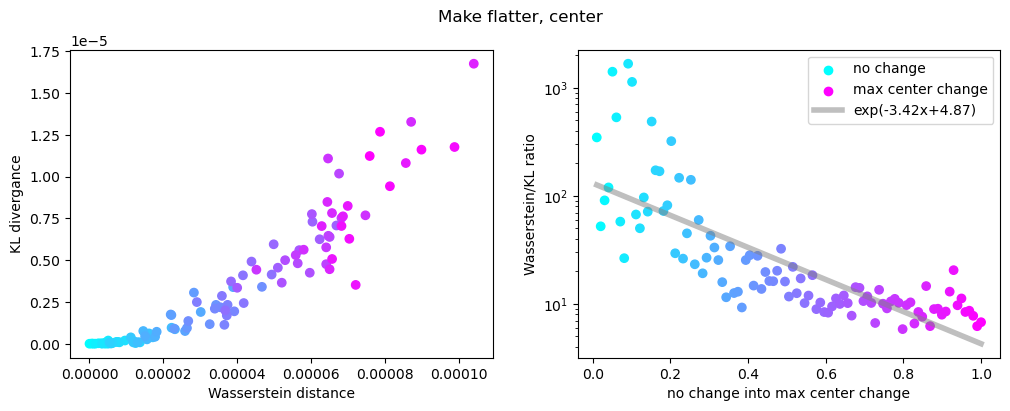

In [103]:
_ = run(None, flatten_center, suptitle="Make flatter, center", center_activation=0.64)

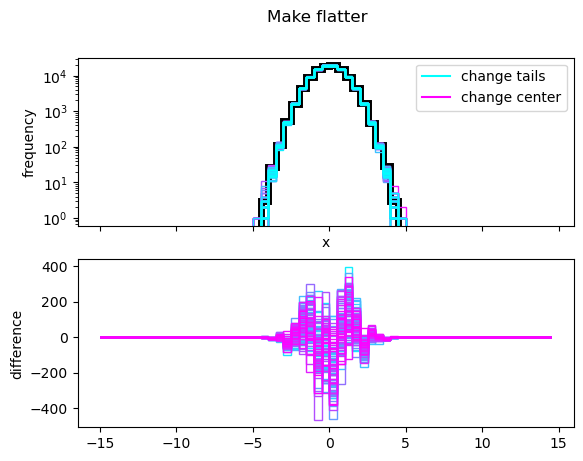

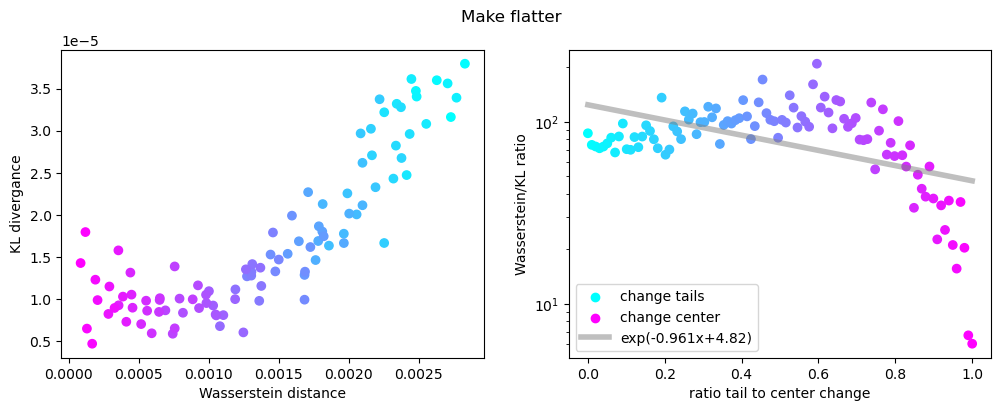

In [104]:
_ = run(flatten_tails, flatten_center, suptitle="Make flatter", center_activation=0.64)

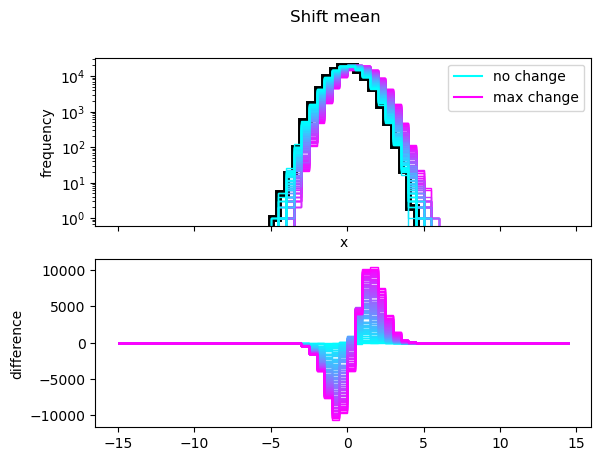

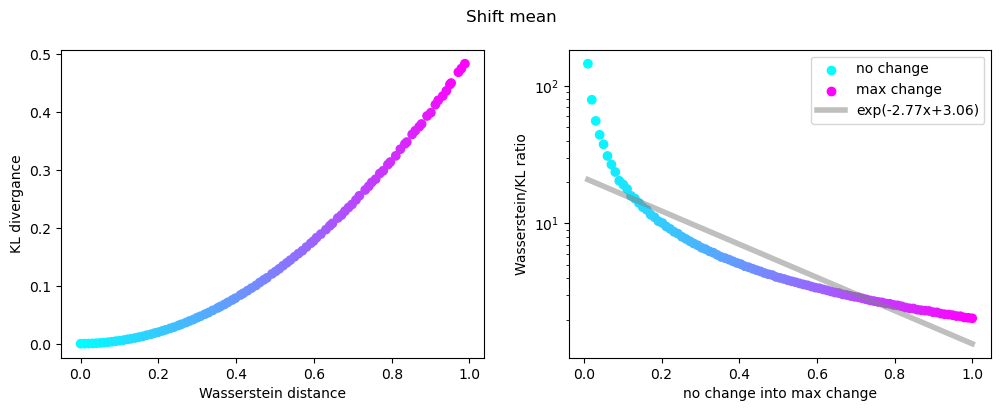

In [105]:
_ = run("mean", None, suptitle="Shift mean")

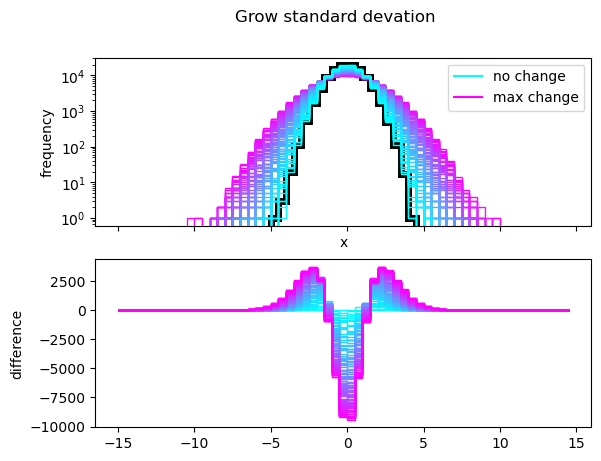

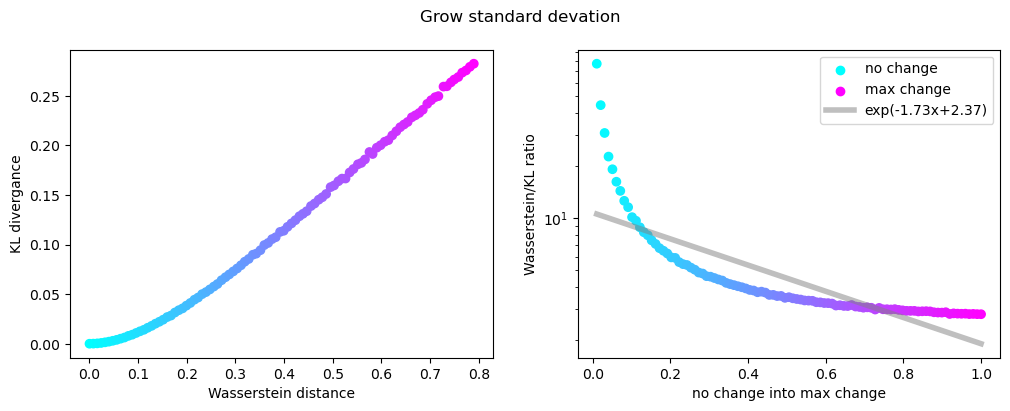

In [106]:
_ = run("std_grow", None, suptitle="Grow standard devation")

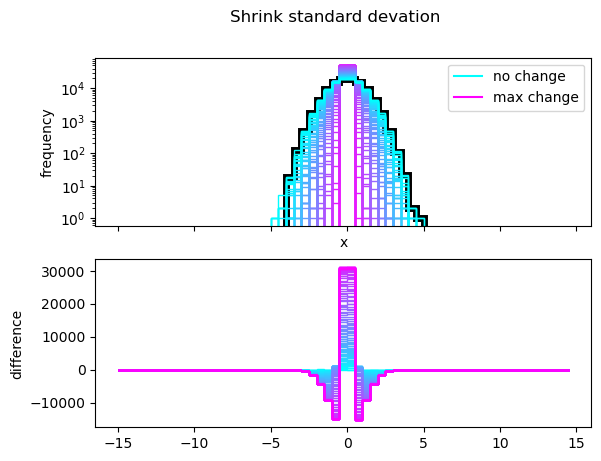

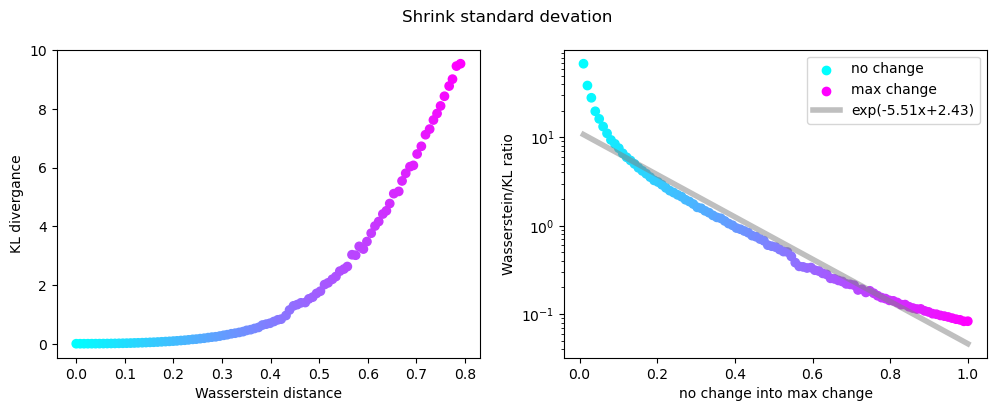

In [107]:
_ = run("std_shrink", None, suptitle="Shrink standard devation")